In [1]:
%matplotlib widget
from datetime import datetime, timedelta
import glob
from eigsep_corr import io, gain_cal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.dates as mdates

In [2]:
DATA_DIR = "/home/christian/Documents/research/eigsep/data-analysis/data/deployment3"
files = sorted(glob.glob(f"{DATA_DIR}/*"))
files = np.array(files)
print(len(files))
hdr = io.read_header(files[0])
print(io.read_header(files[0]).keys())
hdr, data = io.read_file(files[0], header=hdr)
print(data.keys())
print(data['0'].shape)

1800
dict_keys(['dtype', 'infochan', 'nchan', 'acc_bins', 'fpg_file', 'fpg_version', 'sample_rate', 'gain', 'corr_acc_len', 'corr_scalar', 'pol01_delay', 'pol23_delay', 'pol45_delay', 'pam_atten', 'fft_shift', 'pairs', 'acc_cnt', 'sync_time', 'header_size', 'data_start', 'filename', 'filesize', 'nspec', 'freqs', 'dfreq', 'inttime', 'times'])
dict_keys(['0', '1', '2', '3', '4', '5', '02', '04', '24', '13', '15', '35'])
(60, 2, 1024, 1)


[   5   12   56   57  863  885  895 1111 1761]


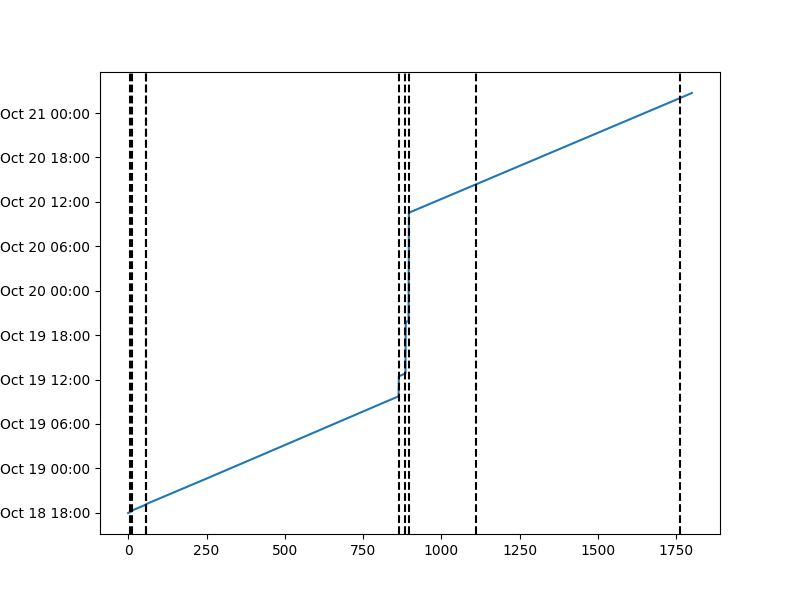

In [3]:
def fname2ts(f):
    t = f[-len("20231014_202203.eig"):-4]
    y = t[:4]
    mo = t[4:6]
    d = t[6:8]
    h = t[9:11]
    mi = t[11:13]
    s = t[13:15]
    dt = datetime.fromisoformat(f"{y}-{mo}-{d} {h}:{mi}:{s}")
    # add one hour to convert from pacific time to local time
    dt = dt + timedelta(hours=1)
    return dt

ftime = np.array([fname2ts(f) for f in files])
timestamps = [ft.timestamp() for ft in ftime]
ix = np.argsort(timestamps)
ftime = ftime[ix]
files = files[ix]

# observing stops when two files are far apart
breaks = np.argwhere(np.diff(timestamps) > np.median(np.diff(timestamps)+1))[:, 0]
print(breaks)

plt.figure(figsize=(8, 6))
plt.plot(ftime)
for b in breaks:
    plt.axvline(b, ls="--", c="k")
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%b %d %H:%M'))
plt.yticks(rotation=0)
plt.ylabel("Local Time")
plt.show()

In [4]:
observing_windows = {
    "win1": (57, 863),  # thursday day + night until friday morning
    "win2": (895, 1760),  # saturday (lift) until monday morning
}

auto = [f"{i}" for i in range(6)]
cross = [f"{i}{i+2}" for i in range(4)] + ["04", "15"]

def load_data(obs_window, pairs=auto+cross):
    mn, mx = observing_windows[obs_window]
    data = {}
    sync_time = None
    acc_cnt = []
    times = []
    for f in files[mn:mx]:
        hdr, dat = io.read_file(f)
        if sync_time is None or hdr["sync_time"] != sync_time:
            print(f, sync_time, hdr["sync_time"])
            sync_time = hdr["sync_time"]
        times.append(hdr["times"])
        acc_cnt.append(hdr["acc_cnt"])
        for k, d in dat.items():
            if k not in pairs:
                continue
            if len(k) == 1:
                d.dtype = io.build_dtype(*hdr["dtype"])
                d = d[..., 0]  # only real part
            else:
                d = d[..., 0] + 1j * d[..., 1]  # complex number
            data[k] = data.get(k, []) + [d]
    for k, v in data.items():
        data[k] = np.concatenate(v, axis=0)
    tmin, tmax = ftime[mn], ftime[mx]
    acc_cnt = np.array(acc_cnt)
    times = np.array(times)
    #times = 2 * (times - times[0, 0]) + times[0, 0]  # fixing time calculation bug
    times += 3600  # pacific time to utah time
    return data, hdr, acc_cnt, times, (tmin, tmax)

#data, hdr, acc_cnt, times, time_range = load_data("night1", pairs=["0", "1", "2", "3", "4", "5", "02", "04", "24", "13", "15", "35"])
#data, hdr, acc_cnt, times, time_range = load_data("win2", pairs=["2", "3", "4", "5", "24", "35"])
observing_windows["win3"] = (1250, 1375)
data, hdr, acc_cnt, times, time_range = load_data("win3", pairs=["2", "4", "24"])
freqs = hdr["freqs"]
print(np.all(np.diff(acc_cnt.ravel()) == 1))  # continuous times

/home/christian/Documents/research/eigsep/data-analysis/data/deployment3/20241020_155216.eig None 1729441860.6774528
False


In [5]:
plt.close("all")

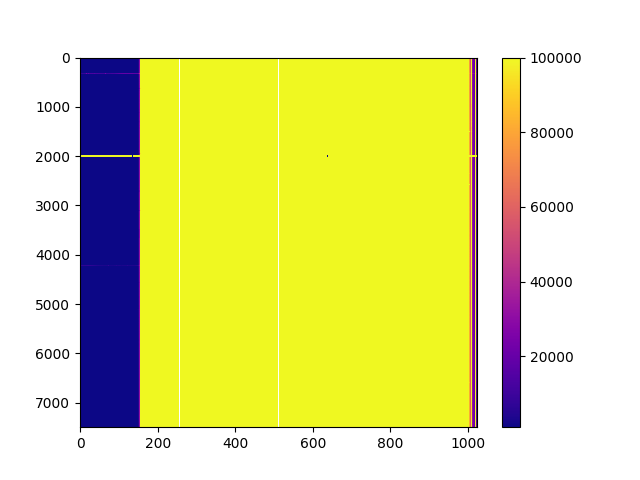

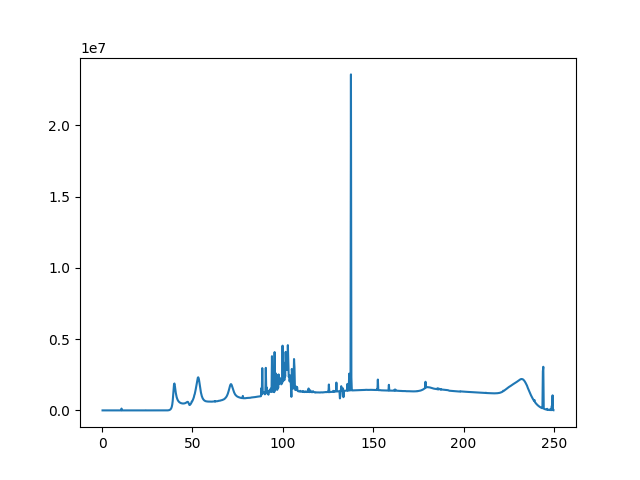

In [6]:
k = "4"
#start = 13800
#stop = 45000
#auto = 1/2 * (data[k][start:stop, 0] + data[k][start:stop, 1])
auto = 1/2 * (data[k][:, 0] + data[k][:, 1])

for i in range(4):
    auto[:, 1024//4*i] = np.nan  # notch sample clock

plt.figure()
plt.imshow(auto, aspect="auto", interpolation="none", cmap="plasma", vmin=1e3, vmax=1e5)
plt.colorbar()
plt.show()


plt.figure()
plt.plot(freqs/1e6, np.mean(auto[4000:6000], axis=0))
plt.show()

In [7]:
k = "5"
#start = 13800
#stop = 45000
#auto = 1/2 * (data[k][start:stop, 0] + data[k][start:stop, 1])
auto = 1/2 * (data[k][:, 0] + data[k][:, 1])

for i in range(4):
    auto[:, 1024//4*i] = np.nan  # notch sample clock

plt.figure()
plt.imshow(auto, aspect="auto", interpolation="none", cmap="plasma", vmin=1e5, vmax=5e6)
plt.colorbar()
plt.show()

plt.figure()
plt.plot(freqs/1e6, auto.mean(axis=0))
plt.show()

KeyError: '5'

In [56]:
def plot_waterfall(data, times, freqs, title=None, auto_ln=colors.LogNorm(vmin=1e7, vmax=1e8)):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=2, ncols=4, sharex=True, sharey=True, constrained_layout=True)
    cross_ln = colors.LogNorm(vmin=1e-4, vmax=1e-1)
    tmin = datetime.fromtimestamp(times[0, 0])
    tmax = datetime.fromtimestamp(times[-1, -1])
    extent = [freqs.min()/1e6, freqs.max()/1e6, tmax, tmin]
    kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    for i, k in enumerate(["24", "35"]):
        autos = {}
        for j in range(2):
            autos[j] = 1/2 * (data[k[j]][:, 0] + data[k[j]][:, 1])
            axs[i, 3*j].imshow(np.abs(autos[j]), norm=auto_ln, **kwargs)
        norm = np.sqrt(autos[0]**2 + autos[1]**2)
        cross = 1/2 * (data[k][:, 0] + data[k][:, 1])
        axs[i, 1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)
        axs[i, 2].imshow(np.angle(cross), aspect="auto", cmap="twilight", extent=extent, interpolation="none", vmin=-np.pi, vmax=np.pi)
    axs[0, 0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    if title:
        plt.suptitle(title)
    plt.show()

def plot_waterfall_singlepol(data, times, freqs, title=None, auto_ln=colors.LogNorm(vmin=1e7, vmax=1e8)):
    fig, axs = plt.subplots(figsize=(8, 6), nrows=1, ncols=4, sharex=True, sharey=True, constrained_layout=True)
    cross_ln = colors.LogNorm(vmin=1e-4, vmax=1e-1)
    tmin = datetime.fromtimestamp(times[0, 0])
    tmax = datetime.fromtimestamp(times[-1, -1])
    extent = [freqs.min()/1e6, freqs.max()/1e6, tmax, tmin]
    #kwargs = {"aspect": "auto", "cmap": "plasma", "extent": extent, "interpolation": "none"}
    kwargs = {"aspect": "auto", "cmap": "plasma", "interpolation": "none"}
    for i, k in enumerate(["24"]):
        autos = {}
        for j in range(2):
            autos[j] = 1/2 * (data[k[j]][:, 0] + data[k[j]][:, 1])
            axs[3*j].imshow(np.abs(autos[j]), norm=auto_ln, **kwargs)
        norm = np.sqrt(autos[0]**2 + autos[1]**2)
        cross = 1/2 * (data[k][:, 0] + data[k][:, 1])
        axs[1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)
        #axs[2].imshow(np.angle(cross), aspect="auto", cmap="twilight", extent=extent, interpolation="none", vmin=-np.pi, vmax=np.pi)
    axs[2].imshow(np.angle(cross), aspect="auto", cmap="twilight", interpolation="none", vmin=-np.pi, vmax=np.pi)
    #axs[0].yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    fig.supxlabel("Frequency [MHz]")
    fig.supylabel("Local Time")
    if title:
        plt.suptitle(title)
    plt.show()
    
#plot_waterfall(data, times, freqs)

In [63]:
132/250 * 1024

540.672

/tmp/ipykernel_298137/2839871792.py:39: RuntimeWarning: invalid value encountered in divide
  axs[1].imshow(np.abs(cross)/norm, norm=cross_ln, **kwargs)


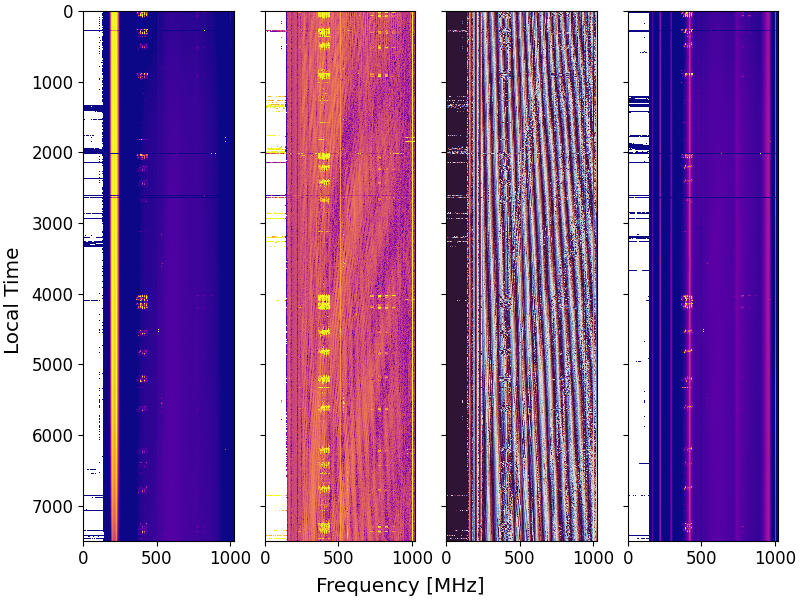

In [57]:
plot_waterfall_singlepol(data, times, freqs, auto_ln=colors.LogNorm(vmin=1e6, vmax=1e7))

In [13]:
fm = (fmhz > 90) & (fmhz < 105)
np.argsort(np.mean(d2[:, fm], axis=1))

array([2640, 2610, 4210, ..., 2641, 2609, 2639])

In [12]:
d2 = data["2"].mean(axis=1)
d24 = data["24"].mean(axis=1)
d4 = data["4"].mean(axis=1)

fmhz = freqs / 1e6

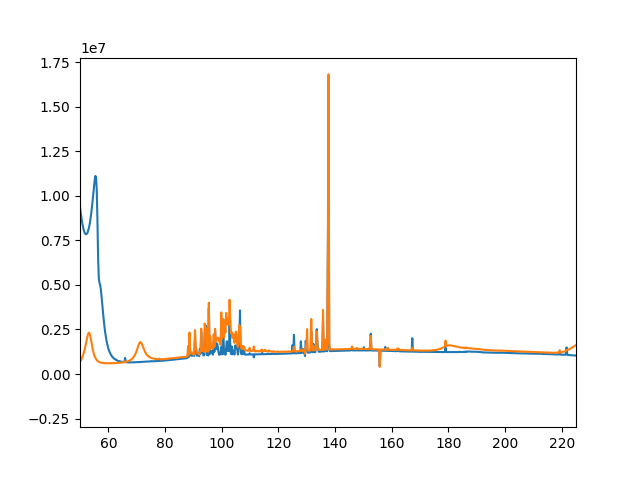

In [28]:

plt.figure()
plt.plot(fmhz, d2.mean(axis=0))
plt.plot(fmhz, d4.mean(axis=0))
plt.xlim(50, 225)
#plt.yscale("log")
plt.show()

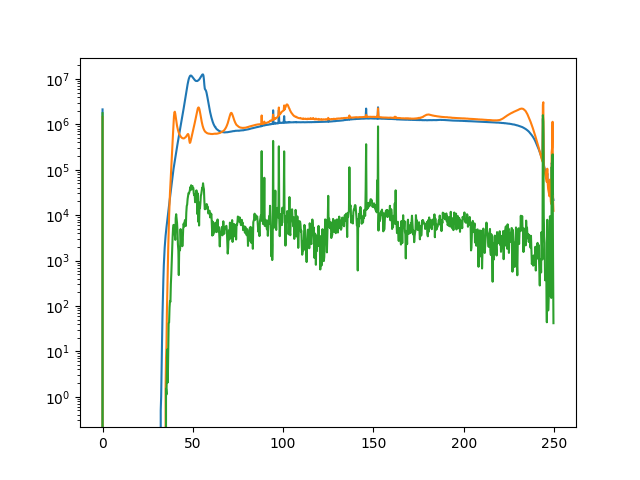

In [15]:
ix = 2950
plt.figure()
plt.plot(fmhz, d2[ix])
plt.plot(fmhz, d4[ix])
plt.plot(fmhz, np.abs(d24[ix]))
#plt.xlim(50, 225)
plt.yscale("log")
plt.show()

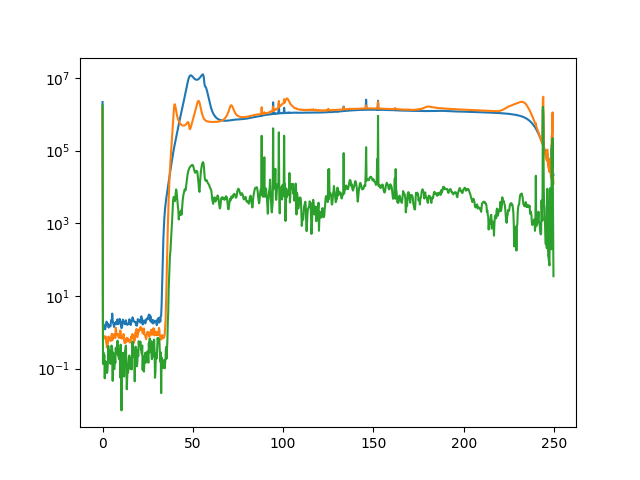

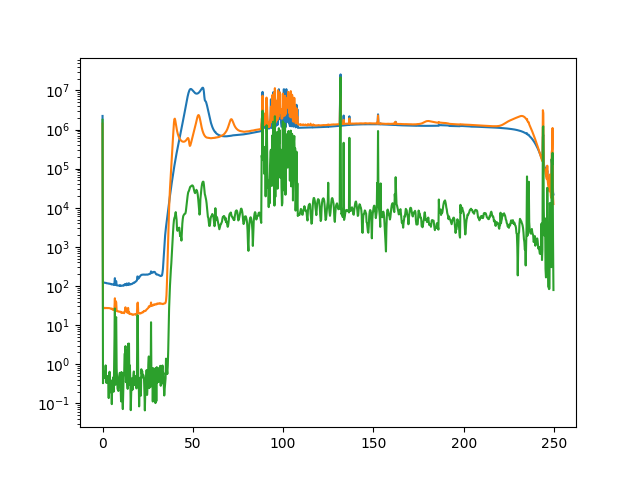

In [17]:
imn = 2920
imx = 3020
plt.figure()
plt.plot(fmhz, d2[imn:imx].mean(axis=0))
plt.plot(fmhz, d4[imn:imx].mean(axis=0))
plt.plot(fmhz, np.abs(d24[imn:imx].mean(axis=0)))
#plt.xlim(50, 225)
plt.yscale("log")
plt.show()

imn2 = 4075
imx2 = 4175
plt.figure()
plt.plot(fmhz, d2[imn2:imx2].mean(axis=0))
plt.plot(fmhz, d4[imn2:imx2].mean(axis=0))
plt.plot(fmhz, np.abs(d24[imn2:imx2].mean(axis=0)))
#plt.xlim(50, 225)
plt.yscale("log")
plt.show()

In [32]:
plt.close("all")

In [39]:

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [48]:
times.ravel()[imx2] - times.ravel()[imn2]

107.37418246269226

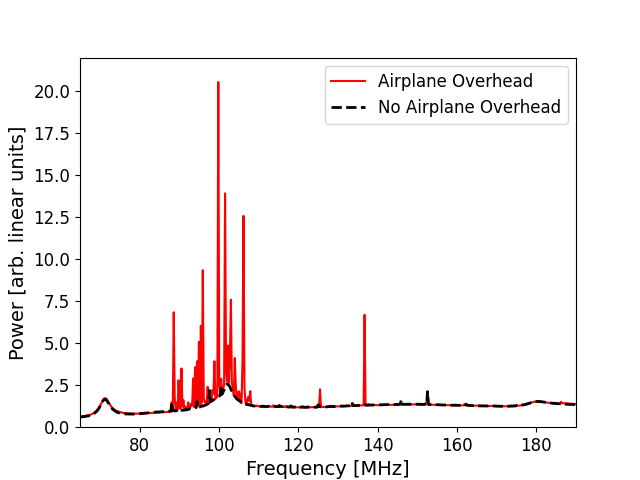

In [75]:
imn = 2920
imx = 3020
#imn2 = 4075
#imx2 = 4175
imn2 = 4800
imx2 = 4900

scale = d4[imn:imx].mean()

plt.figure()
plt.plot(fmhz, d4[imn2:imx2].mean(axis=0) / scale, c="red", label="Airplane Overhead")
plt.plot(fmhz, d4[imn:imx].mean(axis=0) /scale, ls="--", c="k", label="No Airplane Overhead", lw=2)
#plt.xlim(50, 200)
plt.xlim(65, 190)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power [arb. linear units]")
plt.legend()
plt.ylim(0, 22)
plt.savefig("rfi.png", bbox_inches="tight")
plt.show()

In [79]:
10 * np.log10(np.max(d4[imn2:imx2].mean(axis=0) /scale) / 1.83)

10.503137842020553

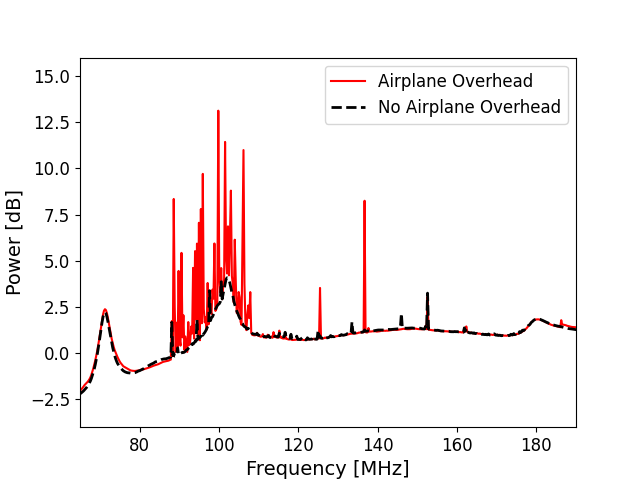

In [74]:
imn = 2920
imx = 3020
#imn2 = 4075
#imx2 = 4175
imn2 = 4800
imx2 = 4900

scale = d4[imn:imx].mean()

plt.figure()
plt.plot(fmhz, 10 * np.log10(d4[imn2:imx2].mean(axis=0) / scale), c="red", label="Airplane Overhead")
plt.plot(fmhz, 10 * np.log10(d4[imn:imx].mean(axis=0) /scale), ls="--", c="k", label="No Airplane Overhead", lw=2)
#plt.xlim(50, 200)
plt.xlim(65, 190)
plt.xlabel("Frequency [MHz]")
plt.ylabel("Power [dB]")
plt.legend()
plt.ylim(-4, 16)
plt.savefig("rfi_dB.png", bbox_inches="tight")
plt.show()

In [69]:
10 * np.log10(22)

13.424226808222063

In [51]:
np.max(d4[imn:imx].mean(axis=0)[(fmhz>95)&(fmhz<98)]) / scale / 1.45

1.5050034964853394